1. Load required packages

In [245]:
from IPython.display import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly_calplot import calplot

import time
import random
import calmap
import warnings
warnings.filterwarnings('ignore')


sns.set_theme(style="darkgrid")
current_palette = sns.color_palette()


In [120]:
pd.options.display.min_rows = 20
pd.options.display.max_columns = 500


Machine Learning Process

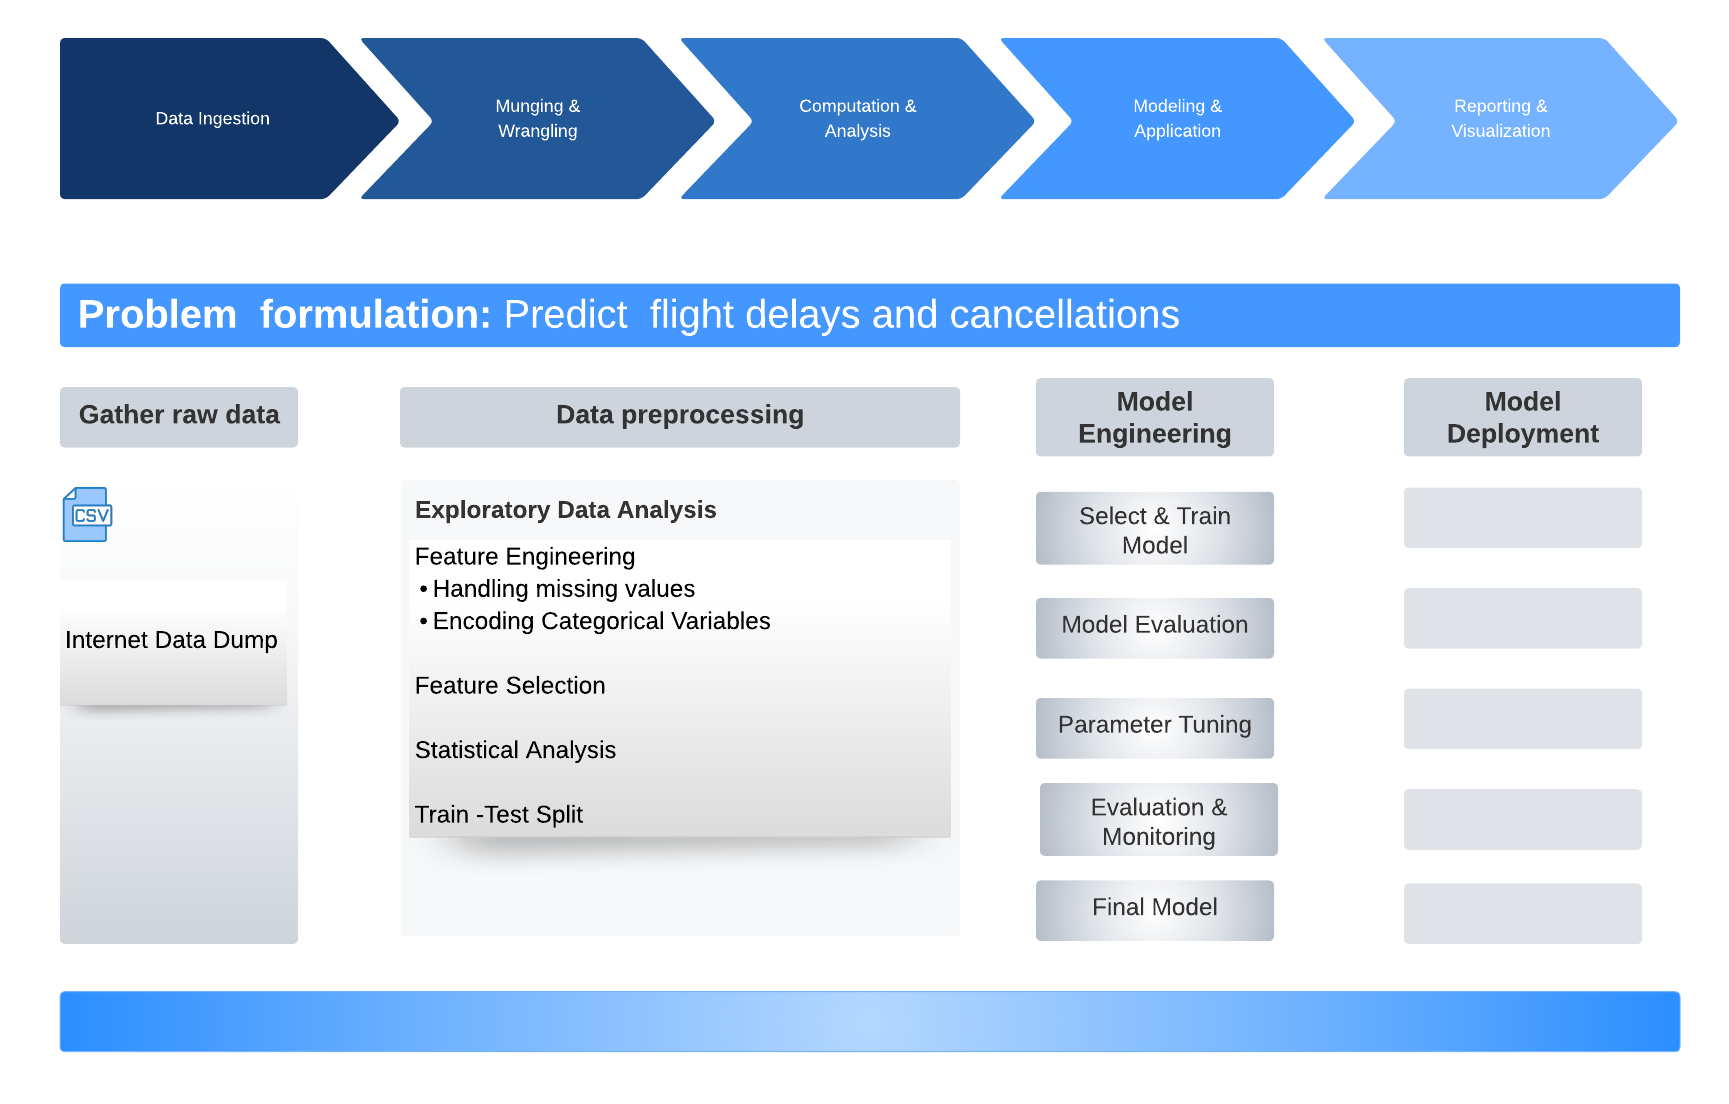

In [268]:
Image("../../data/images/MLProcess.png")

### Load in the data

In [122]:
n= 40000000
s= 1000000
skip = sorted(random.sample(range(1,n),n-s))
df_flights = pd.read_csv("../../data/eda/flights/all_flight_data_20182022/all_flight_data_20182022.zip",skiprows=skip, low_memory=False)


In [123]:
df_flights = df_flights.rename(columns={"Operating_Airline ": "Operating_Airline", "Flight_Number_Operating_Airline": "Flight_Number"})

In [124]:
airlines = pd.read_csv(
    "../../data/databases/flight_attributes/airlines.csv.zip", low_memory=False)
airline_mapper = airlines.set_index("Code")["Description"]

In [125]:
cancellation_codes = pd.read_csv(
    "../../data/databases/flight_attributes/cancellation_codes.csv", low_memory=False)
cancellation_code_mapper = cancellation_codes.set_index(
    "CANCELLATION_REASON")["CANCELLATION_DESCRIPTION"]


In [126]:
usa_airports = (pd.read_csv("../../data/databases/flight_attributes/usa_airports.csv.zip",
                            usecols= ["iata","latitude","longitude"], 
                            low_memory=False))
usa_airports = usa_airports.rename(columns={"iata": "Origin"})



### Data Pre-processing Phase
- EDA
- Feature Engineering
  - Handling missing values
  - Encoding Categorical Variables
- Feature Selection 
- Statistical Analysis
- Train - Test Split

In [127]:
def airline_mapping(df_flights):
    df_flights["Operating_Airline"] = (
        df_flights["Operating_Airline"].map(airline_mapper))
    df_flights["CancellationCode"] = (
        df_flights["CancellationCode"].map(cancellation_code_mapper))
    return df_flights

def tweak_df_flights(df_flights):
    SELECTED_COLUMNS = ["FlightDate", "Operating_Airline", "Tail_Number", "Flight_Number", "OriginAirportID",
                        "Origin", "OriginCityName", "OriginState", "OriginStateName", "DestAirportID", "Dest", "DestCityName",
                        "DestState", "DestStateName", "CRSDepTime", "DepTime", "DepDelay", "DepDel15", "DepDelayMinutes", "DepTimeBlk",
                        "TaxiOut", "WheelsOn", "TaxiIn", "CRSArrTime", "ArrTime", "ArrDelayMinutes", "ArrDel15", "ArrTimeBlk",
                        "Cancelled", "CancellationCode", "Diverted", "CRSElapsedTime", "AirTime", "Distance", "CarrierDelay",
                        "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay", "FirstDepTime", "TotalAddGTime",
                        ]
    df_flights = (
        df_flights[SELECTED_COLUMNS]
        .copy()
    )
    df_flights = (pd.merge(df_flights, usa_airports, how="left", on=["Origin"]))
    df_flights.pipe(airline_mapping)
    return df_flights.assign(
        DepTime=df_flights.DepTime.fillna(0).astype("float16"),
        DepDelay=df_flights.DepDelay.fillna(0).astype("float16"),
        DepDel15=df_flights.DepDel15.fillna(0).astype("float16"),
        DepDelayMinutes=df_flights.DepDelayMinutes.fillna(0).astype("float16"),
        TaxiOut=df_flights.TaxiOut.fillna(0).astype("float16"),
        WheelsOn=df_flights.WheelsOn.fillna(0).astype("float16"),
        TaxiIn=df_flights.TaxiIn.fillna(0).astype("float16"),
        ArrDel15=df_flights.ArrDel15.fillna(0).astype("float16"),
        ArrDelayMinutes=df_flights.ArrDelayMinutes.fillna(0).astype("float16"),
        CRSElapsedTime=df_flights.CRSElapsedTime.fillna(0).astype("float16"),
        ArrTime=df_flights.ArrTime.fillna(0).astype("float16"),
        AirTime=df_flights.AirTime.fillna(0).astype("float16"),
        Distance=df_flights.Distance.fillna(0).astype("float16"),
        CarrierDelay=df_flights.CarrierDelay.fillna(0).astype("float16"),
        WeatherDelay=df_flights.WeatherDelay.fillna(0).astype("float16"),
        NASDelay=df_flights.NASDelay.fillna(0).astype("float16"),
        SecurityDelay=df_flights.SecurityDelay.fillna(0).astype("float16"),
        LateAircraftDelay=df_flights.LateAircraftDelay.fillna(
            0).astype("float16"),
        FirstDepTime=df_flights.FirstDepTime.fillna(0).astype("float16"),
        TotalAddGTime=df_flights.TotalAddGTime.fillna(0).astype("float16"),
        CancellationCode=df_flights.CancellationCode.fillna(
            "none").astype("category"),
        Tail_Number=df_flights.Tail_Number.fillna("none").astype("category"),
        FlightDate=pd.to_datetime(df_flights.FlightDate)
    ).astype(
        {
            "Operating_Airline": "category",
            "Origin": "category",
            "Dest": "category",
            "DestState": "category",
            "OriginState": "category",
            "OriginCityName": "category",
            "OriginStateName": "category",
            "DestStateName": "category",
            "DestCityName": "category",
            "DepTimeBlk": "category",
            "ArrTimeBlk": "category",
            #"Cancelled": "bool",
            "Diverted": "bool",
            "OriginAirportID": "int16",
            "DestAirportID": "int16",
            "CRSDepTime": "int16",
            "CRSArrTime": "int16",
            "Flight_Number": "int16",
            "latitude": "float16",
            "longitude": "float16"
        }
    )


df_flights = tweak_df_flights(df_flights)

##########Flight Status Categories####################
###############DepDelayGroups#########################
# Departure Delay intervals until 180 mins
def DepDelay_Class(df_flights):
    df_flights["DepDelayClass"] = None
    df_flights.loc[df_flights["DepDelayMinutes"] <= 15, "DepDelayClass"] = "OnTime"
    df_flights.loc[(df_flights["DepDelayMinutes"] > 15) & (df_flights["DepDelayMinutes"] <= 45), "DepDelayClass"] = "Delay15_45"
    df_flights.loc[(df_flights["DepDelayMinutes"] > 45), "DepDelayClass"] = "Delay45_180"
    df_flights.loc[(df_flights["Cancelled"] > 0), "DepDelayClass"] = "Cancelled"
    
DepDelay_Class(df_flights)
df_flights["DepDelayClass"].astype("category")


print(df_flights.shape)
df_flights.tail()


(745246, 44)


,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,Origin,OriginCityName,OriginState,OriginStateName,DestAirportID,Dest,DestCityName,DestState,DestStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,latitude,longitude,DepDelayClass
745241,2022-08-12,Comair Inc.,N593NN,5291,11057,CLT,"Charlotte, NC",NC,North Carolina,12448,JAN,"Jackson/Vicksburg, MS",MS,Mississippi,2240,2236.0,-5.0,0.0,0.0,2200-2259,27.0,2324.0,10.0,2342,2332.0,0.0,0.0,2300-2359,0.0,none,False,122.0,81.0,562.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.21875,-80.9375,OnTime
745242,2022-08-31,Comair Inc.,N549NN,5291,11057,CLT,"Charlotte, NC",NC,North Carolina,12448,JAN,"Jackson/Vicksburg, MS",MS,Mississippi,2240,2232.0,-7.0,0.0,0.0,2200-2259,21.0,2312.0,8.0,2340,2320.0,0.0,0.0,2300-2359,0.0,none,False,120.0,79.0,562.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.21875,-80.9375,OnTime
745243,2022-08-02,Comair Inc.,N520DC,5292,11057,CLT,"Charlotte, NC",NC,North Carolina,15412,TYS,"Knoxville, TN",TN,Tennessee,2040,2033.0,-7.0,0.0,0.0,2000-2059,35.0,2140.0,6.0,2142,2146.0,4.0,0.0,2100-2159,0.0,none,False,62.0,32.0,177.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.21875,-80.9375,OnTime
745244,2022-08-24,Comair Inc.,N608NN,5293,12217,HSV,"Huntsville, AL",AL,Alabama,11057,CLT,"Charlotte, NC",NC,North Carolina,1914,1903.0,-11.0,0.0,0.0,1900-1959,8.0,2108.0,11.0,2150,2120.0,0.0,0.0,2100-2159,0.0,none,False,96.0,58.0,333.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.62500,-86.7500,OnTime
745245,2022-08-17,Comair Inc.,N594NN,5294,11278,DCA,"Washington, DC",VA,Virginia,12323,ILM,"Wilmington, NC",NC,North Carolina,834,824.0,-10.0,0.0,0.0,0800-0859,46.0,1010.0,6.0,1006,1016.0,10.0,0.0,1000-1059,0.0,none,False,92.0,60.0,319.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.84375,-77.0625,OnTime


In [294]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 745246 entries, 0 to 745245
Data columns (total 47 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   FlightDate         745246 non-null  datetime64[ns]
 1   Operating_Airline  745246 non-null  category      
 2   Tail_Number        745246 non-null  category      
 3   Flight_Number      745246 non-null  int16         
 4   OriginAirportID    745246 non-null  int16         
 5   Origin             745246 non-null  category      
 6   OriginCityName     745246 non-null  category      
 7   OriginState        745246 non-null  category      
 8   OriginStateName    745246 non-null  category      
 9   DestAirportID      745246 non-null  int16         
 10  Dest               745246 non-null  category      
 11  DestCityName       745246 non-null  category      
 12  DestState          745246 non-null  category      
 13  DestStateName      745246 non-null  category

Feature Selection 

In [128]:
#df_flights.columns.to_list()

In [129]:
####Feature Selection#####
ml_cols = [
    'FlightDate',
    'Operating_Airline',
    'Tail_Number',
    'Flight_Number',
    'OriginAirportID',
    #'Origin',
    #'OriginCityName',
    #'OriginState',
    #'OriginStateName',
    'DestAirportID',
    #'Dest',
    #'DestCityName',
    #'DestState',
    #'DestStateName',
    'CRSDepTime',
    'DepTime',
    #'DepDelay',
    #'DepDel15',
    'DepDelayMinutes',
    #'DepTimeBlk',
    'TaxiOut',
    'WheelsOn',
    'TaxiIn',
    'CRSArrTime',
    #'ArrTime',
    #'ArrDelayMinutes',
    #'ArrDel15',
    #'ArrTimeBlk',
    'Cancelled',
    #'CancellationCode',
    #'Diverted',
    'CRSElapsedTime',
    'AirTime',
    'Distance',
    #'CarrierDelay',
    #'WeatherDelay',
    #'NASDelay',
    #'SecurityDelay',
    #'LateAircraftDelay',
    #'FirstDepTime',
    'TotalAddGTime',
    'latitude',
    'longitude',
    'DepDelayClass',
    ]

df_flights_2= df_flights[ml_cols]
df_flights_2.columns

Index(['FlightDate', 'Operating_Airline', 'Tail_Number', 'Flight_Number',
       'OriginAirportID', 'DestAirportID', 'CRSDepTime', 'DepTime',
       'DepDelayMinutes', 'TaxiOut', 'WheelsOn', 'TaxiIn', 'CRSArrTime',
       'Cancelled', 'CRSElapsedTime', 'AirTime', 'Distance', 'TotalAddGTime',
       'latitude', 'longitude', 'DepDelayClass'],
      dtype='object')

Statistical Analysis
- Flights per airline
- Distribution of flight delays by year
- Distribution of flight delays by airline
- Distribution of flight cancellations by airline
- Most reliable airline (on time)

In [272]:
#Flights per airline
px.bar(
    df_flights["Operating_Airline"]
    .value_counts()
    .sort_values(ascending=True),
    orientation='h',
    template="plotly_dark",
    title="Number of Flights per airline",
    height=700,
)

Text(0.5, 0, 'Number of Flights ')

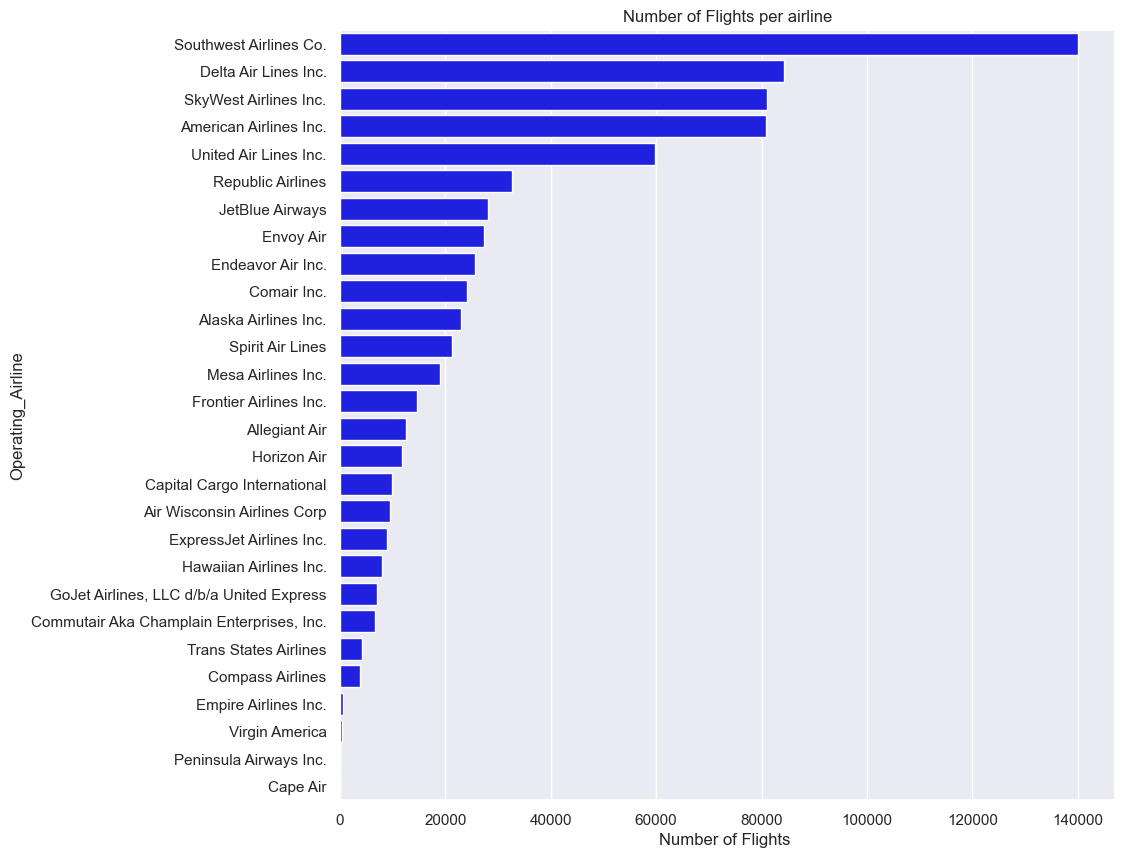

In [284]:
fig,ax = plt.subplots(figsize=(10,10))
sorted_airlines = df_flights["Operating_Airline"].value_counts().index.tolist()
sns.countplot(y=df_flights["Operating_Airline"], order=sorted_airlines, color='blue')
ax.set_title("Number of Flights per airline")
ax.set_xlabel("Number of Flights ")

In [131]:
fig = px.line(df_flights
              .groupby("FlightDate")
              [["DepDelayMinutes"]]
              .mean(),
              title="Distribution of flight delays"
              )
fig.show()


In [132]:
fig = px.bar(df_flights
              .groupby("Operating_Airline")
              [["DepDelayMinutes"]]
              .mean(),
              title="Distribution of flight delays by airline"
              )
fig.show()

In [320]:
fig = px.line(df_flights
              .groupby("FlightDate")
              [["Cancelled"]]
              .mean(),
              title="Distribution of flight cancellations"
              )
fig.show()

In [310]:
fig = px.bar(df_flights
              .groupby("Operating_Airline")
              [["Cancelled"]]
              .mean(),
              title="Distribution of flight cancellations by airline",
              height=700
              )
fig.show()

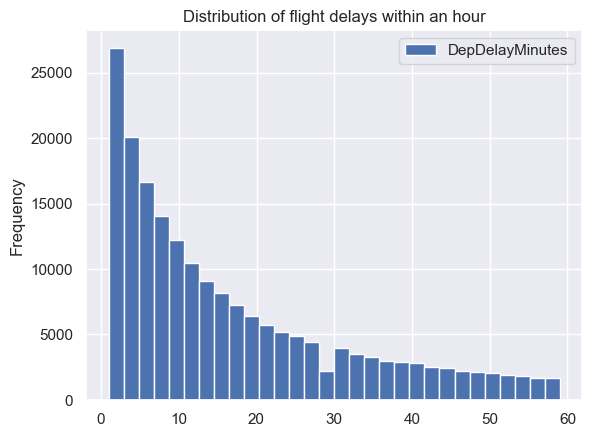

In [134]:
(df_flights
 .query("DepDelayMinutes > 0 and DepDelayMinutes < 60")
 [["DepDelayMinutes"]]
 .plot(kind="hist", bins=30, title="Distribution of flight delays within an hour"))
plt.show()


In [135]:
df_flights_2.head()

,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,DestAirportID,CRSDepTime,DepTime,DepDelayMinutes,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,Cancelled,CRSElapsedTime,AirTime,Distance,TotalAddGTime,latitude,longitude,DepDelayClass
0,2018-01-16,Endeavor Air Inc.,N8775A,3299,10397,11612,939,932.0,0.0,25.0,952.0,5.0,1008,0.0,89.0,55.0,350.0,0.0,33.6250,-84.4375,OnTime
1,2018-01-22,Endeavor Air Inc.,N8946A,3299,10397,11612,939,932.0,0.0,17.0,951.0,4.0,1008,0.0,89.0,62.0,350.0,0.0,33.6250,-84.4375,OnTime
2,2018-01-03,Endeavor Air Inc.,N8972E,3301,11617,10397,1415,1420.0,5.0,12.0,1547.0,4.0,1605,0.0,110.0,75.0,433.0,0.0,35.0625,-77.0625,OnTime
3,2018-01-07,Endeavor Air Inc.,N8936A,3302,10397,11641,1708,1701.0,0.0,17.0,1805.0,4.0,1828,0.0,80.0,47.0,331.0,0.0,33.6250,-84.4375,OnTime
4,2018-01-30,Endeavor Air Inc.,N8896A,3305,10397,14108,1001,950.0,0.0,27.0,1048.0,12.0,1103,0.0,122.0,91.0,565.0,0.0,33.6250,-84.4375,OnTime


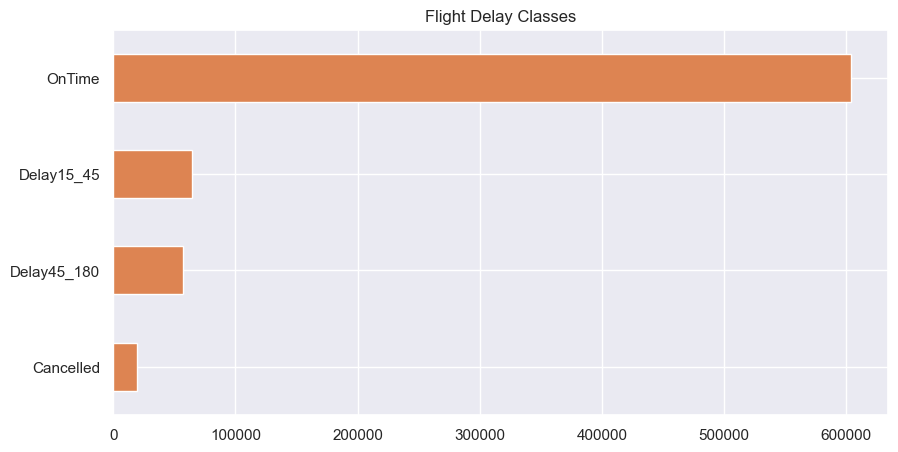

In [136]:
(df_flights
 .DepDelayClass
 .value_counts(ascending=True)
 .plot(kind='barh', figsize=(10,5), color=current_palette[1], title="Flight Delay Classes")
 )
plt.show()

Percentage of flights per year 

In [137]:
df_flights["Year"] = df_flights["FlightDate"].dt.year
df_flights_agg = df_flights.groupby("Year")["DepDelayClass"].value_counts(normalize=True).unstack()*100
df_flights_agg.style.background_gradient(cmap="YlGnBu")

DepDelayClass,Cancelled,Delay15_45,Delay45_180,OnTime
Year,,,,
2018,1.532909,9.516138,8.378591,80.572361
2019,1.852648,9.099669,8.621806,80.425877
2020,5.925291,4.559138,3.709264,85.806308
2021,1.709992,8.861040,7.420313,82.008654
2022,3.004248,10.777686,9.702481,76.515585


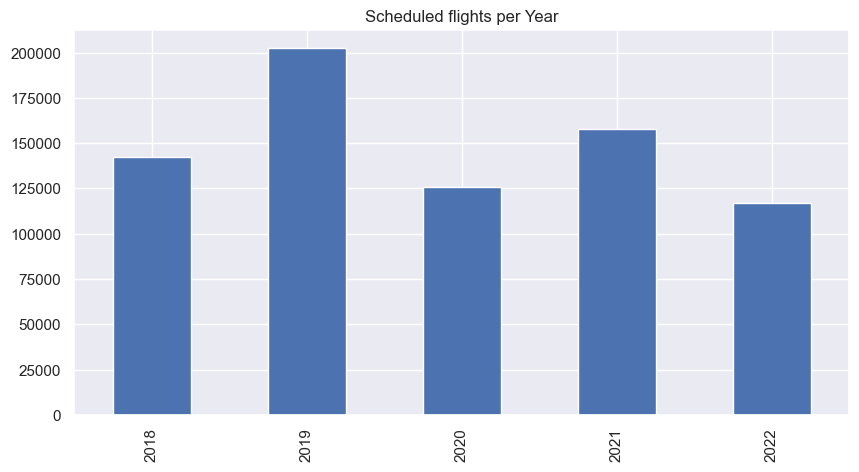

In [138]:
df_flights["Year"].value_counts().sort_index().plot(kind="bar", figsize=(10,5), title="Scheduled flights per Year")
plt.show()

In [139]:
px.bar(
    df_flights["Year"]
    .value_counts()
    .sort_values(ascending=True),
    orientation='v',
    template="plotly_dark",
    title="Scheduled flights per year",
    height=700,
)

Percentage of Flights by Month

In [140]:
df_flights["Month"] = df_flights["FlightDate"].dt.month
df_flights_agg = df_flights.groupby("Month")["DepDelayClass"].value_counts(normalize=True).unstack()*100
df_flights_agg.style.background_gradient(cmap="YlGnBu")

DepDelayClass,Cancelled,Delay15_45,Delay45_180,OnTime
Month,,,,
1,3.060576,7.857597,7.078783,82.003044
2,3.099827,8.685973,7.516740,80.697461
3,5.557140,7.494583,6.207231,80.741047
4,6.722929,7.870437,6.780146,78.626488
5,1.879998,9.061861,7.721179,81.336963
6,1.879699,10.579312,10.700209,76.840780
7,1.663294,9.997620,9.881576,78.457510
8,2.169024,9.595434,9.445022,78.790520
9,1.313104,6.715434,5.960444,86.011018


- Why the high cancellations in March - April?
- Lets analyse per year for these months 

In [170]:
df_flights["Month"] = df_flights["FlightDate"].dt.month
df_flights_agg = df_flights.query("3 <= Month <= 4").groupby("Year")["DepDelayClass"].value_counts(normalize=True).unstack()*100
df_flights_agg.style.background_gradient(cmap="YlGnBu")

DepDelayClass,Cancelled,Delay15_45,Delay45_180,OnTime
Year,,,,
2018,1.658101,9.749830,7.233589,81.358480
2019,2.059415,8.495088,7.858918,81.586578
2020,24.555685,3.139309,2.890958,69.414047
2021,0.930766,5.550597,3.948319,89.570317
2022,1.850590,10.946766,9.535819,77.666826


The analysis shows that the majority of cancellations happened in 2020 March -April 2020, which was when we had covid-19

- How about the situation without 2020?

In [171]:
df_flights["Month"] = df_flights["FlightDate"].dt.month
df_flights_agg = df_flights.query("Year != 2020").groupby("Month")["DepDelayClass"].value_counts(normalize=True).unstack()*100
df_flights_agg.style.background_gradient(cmap="YlGnBu")

DepDelayClass,Cancelled,Delay15_45,Delay45_180,OnTime
Month,,,,
1,3.652986,7.998509,7.455073,80.893432
2,3.899258,9.299475,7.867897,78.933370
3,1.768985,8.698301,7.066418,82.466296
4,1.590083,8.821221,7.601731,81.986965
5,1.493802,9.651692,8.242618,80.611888
6,2.038078,11.359209,11.614658,74.988055
7,1.796065,10.958075,10.959805,76.286055
8,2.344821,10.545983,10.511716,76.597481
9,1.413367,7.368782,6.619269,84.598582


  Observations
  - Without the year 2020 when covid-19 was at its peak, we see that most cancellations happened in the months of January and February, this would be due to the weather
    - Winter: December, January, February
    - Spring: March, April, May
    - Summer: June, July, August
    - Autumn: September, October, November

Lets group by Month and Year analyse the cancellations

In [190]:
df_flights_agg = df_flights.query("Cancelled > 0").groupby(["Month", "Year"]).size().unstack()
df_flights_agg.style.background_gradient(cmap="YlGnBu")

Year,2018,2019,2020,2021,2022
Month,,,,,
1,342.000000,484.000000,209.000000,112.000000,924.000000
2,106.000000,483.000000,138.000000,493.000000,604.000000
3,230.000000,301.000000,2969.000000,161.000000,237.000000
4,112.000000,395.000000,3359.000000,58.000000,306.000000
5,94.000000,344.000000,301.000000,57.000000,316.000000
6,85.000000,353.000000,26.000000,210.000000,461.000000
7,166.000000,352.000000,80.000000,239.000000,281.000000
8,299.000000,306.000000,106.000000,446.000000,386.000000
9,226.000000,248.000000,67.000000,186.000000,nan


(<Figure size 2000x1000 with 5 Axes>,
 array([<AxesSubplot: ylabel='2018'>, <AxesSubplot: ylabel='2019'>,
        <AxesSubplot: ylabel='2020'>, <AxesSubplot: ylabel='2021'>,
        <AxesSubplot: ylabel='2022'>], dtype=object))

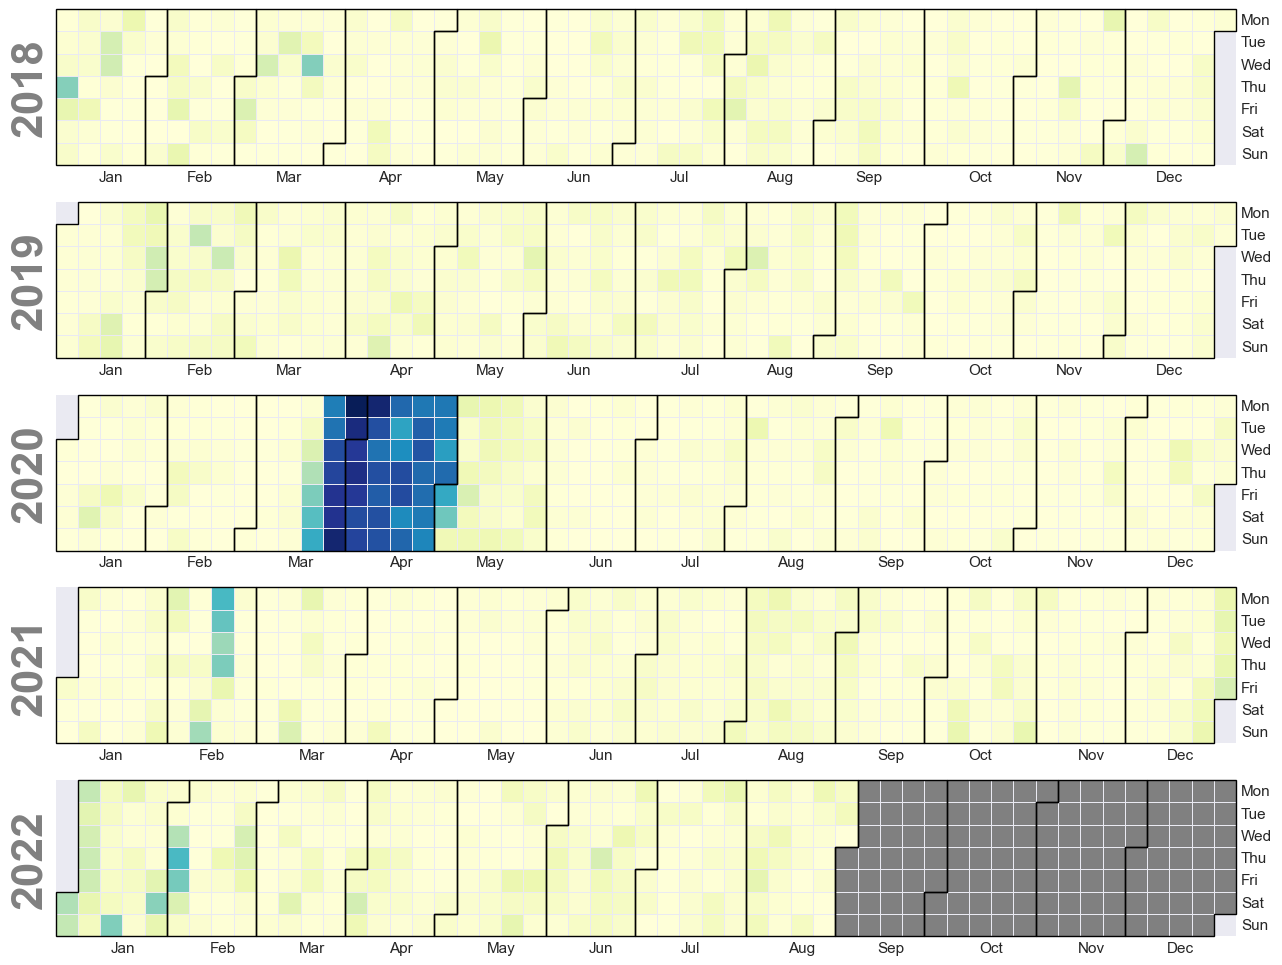

In [266]:
events = df_flights.groupby("FlightDate")["Cancelled"].mean()
calmap.calendarplot(events, monthticks=3, daylabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
                    dayticks=True, cmap='YlGnBu',
                    fillcolor='grey', linewidth=0.5, monthly_border=True, 
                    fig_kws=dict(figsize=(20, 10)))

In [262]:
fig = calplot(
         events.reset_index(),
         x="FlightDate",
         y="Cancelled",
         colorscale="Reds",
         years_title=True
)
fig.show()

In [297]:
df_flights.groupby(["Operating_Airline"])[["DepDelayClass"]].value_counts(normalize=True).unstack()

DepDelayClass,Cancelled,Delay15_45,Delay45_180,OnTime
Operating_Airline,,,,
Air Wisconsin Airlines Corp,0.034014,0.057980,0.089587,0.818420
Alaska Airlines Inc.,0.016810,0.082182,0.047954,0.853054
Allegiant Air,0.045680,0.110320,0.096400,0.747600
American Airlines Inc.,0.030381,0.087880,0.079991,0.801748
Cape Air,0.000000,0.070175,0.000000,0.929825
Capital Cargo International,0.041869,0.060118,0.069140,0.828873
Comair Inc.,0.032900,0.074501,0.079680,0.812920
"Commutair Aka Champlain Enterprises, Inc.",0.038513,0.084819,0.135921,0.740746
Compass Airlines,0.011628,0.077003,0.076744,0.834625


<AxesSubplot: ylabel='Operating_Airline'>

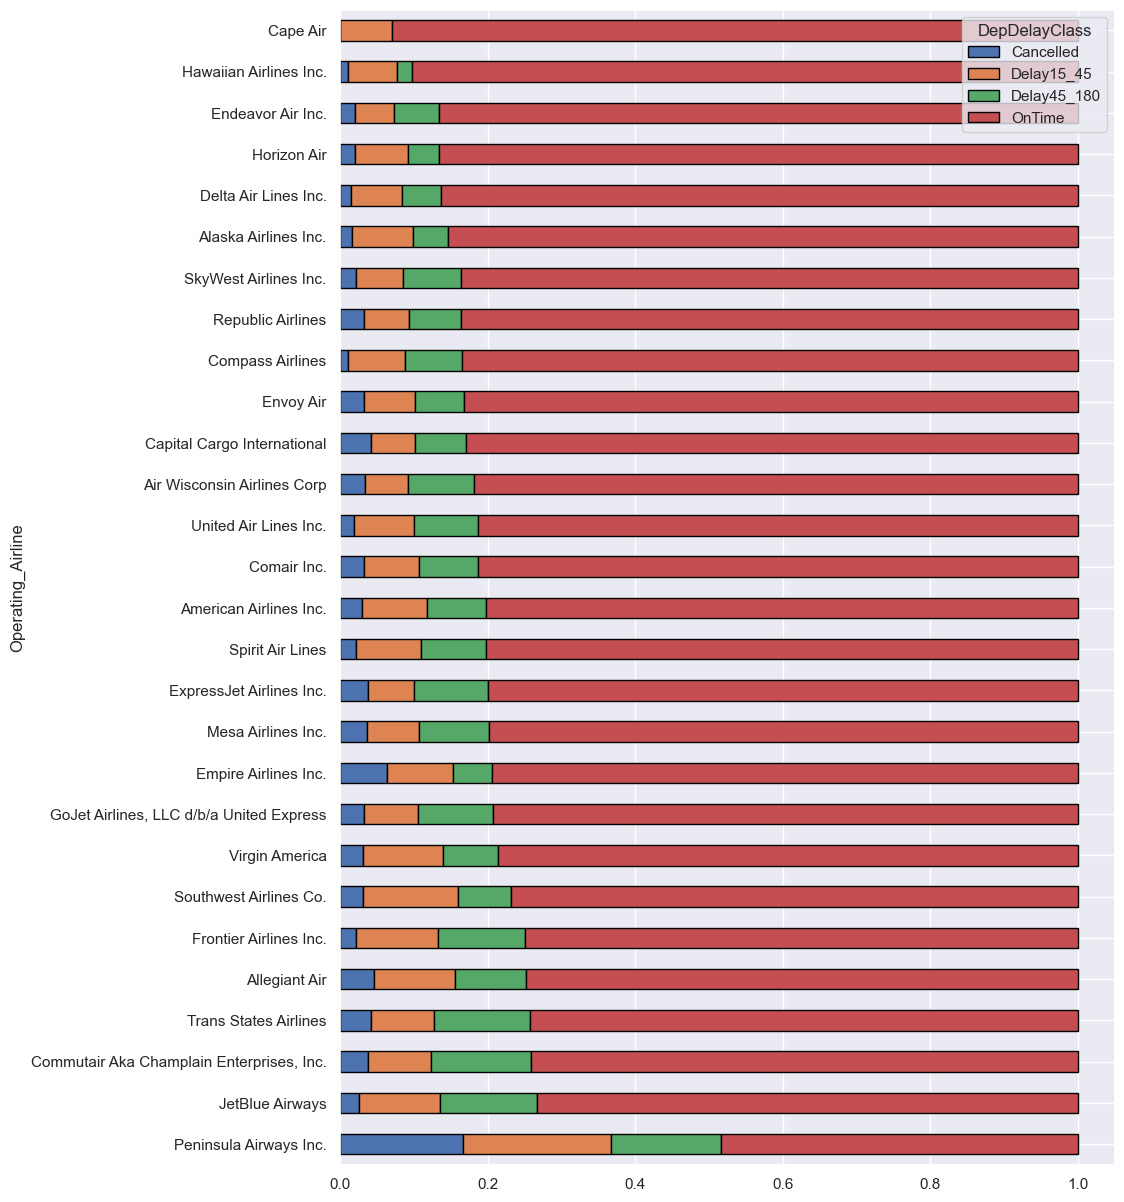

In [315]:
stacked_df_flights = df_flights.groupby(["Operating_Airline"])[["DepDelayClass"]].value_counts(normalize=True).unstack()
stacked_df_flights.sort_values("OnTime").plot(kind='barh', figsize=(10,15), stacked=True, edgecolor="black")

In [314]:
fig = px.bar(stacked_df_flights.sort_values("OnTime"), barmode='stack', height=700, orientation='h')
fig.show()


Handling Ordinal Categorical Variables [Label Encoding]

In [ ]:
# assign the feature with ranks [Ordinal numbering encoding (Label Encoding)]
DepDelayClass_mapping = {"OnTime": '0'}


def DepDelay_Class(df_flights):
    df_flights["DepDelayClass"] = None
    df_flights.loc[df_flights["DepDelayMinutes"] <= 15, "DepDelayClass"] = "OnTime"
    df_flights.loc[(df_flights["DepDelayMinutes"] > 15) & (df_flights["DepDelayMinutes"] <= 45), "DepDelayClass"] = "Delay15_45"
    df_flights.loc[(df_flights["DepDelayMinutes"] > 45), "DepDelayClass"] = "Delay45_180"
    df_flights.loc[(df_flights["Cancelled"] > 0), "DepDelayClass"] = "Cancelled"

#### Correlation [Pearson]

In [321]:
corr = (df_flights_2
        .select_dtypes('float16')
        .corr())
corr.style.background_gradient(cmap='coolwarm')


,DepTime,DepDelayMinutes,TaxiOut,WheelsOn,TaxiIn,CRSElapsedTime,AirTime,Distance,TotalAddGTime,latitude,longitude
DepTime,1.000000,0.123623,0.112171,0.729914,0.043094,-0.015386,0.076659,-0.007862,0.019715,-0.034727,-0.004212
DepDelayMinutes,0.123623,1.000000,0.063800,0.036108,0.025842,0.014517,0.018387,0.011044,0.221319,-0.002896,0.026863
TaxiOut,0.112171,0.063800,1.000000,0.135590,0.077479,0.068519,0.103447,0.029774,0.024210,0.082621,0.101466
WheelsOn,0.729914,0.036108,0.135590,1.000000,0.074381,0.025386,0.122376,0.026293,-0.015207,-0.016089,-0.002672
TaxiIn,0.043094,0.025842,0.077479,0.074381,1.000000,0.098851,0.119128,0.068009,-0.001234,-0.002065,0.048500
CRSElapsedTime,-0.015386,0.014517,0.068519,0.025386,0.098851,1.000000,0.946557,0.981730,0.009149,-0.039436,-0.030611
AirTime,0.076659,0.018387,0.103447,0.122376,0.119128,0.946557,1.000000,0.943749,-0.003205,-0.055545,-0.061495
Distance,-0.007862,0.011044,0.029774,0.026293,0.068009,0.981730,0.943749,1.000000,0.004941,-0.073798,-0.123411
TotalAddGTime,0.019715,0.221319,0.024210,-0.015207,-0.001234,0.009149,-0.003205,0.004941,1.000000,0.006220,0.018670
latitude,-0.034727,-0.002896,0.082621,-0.016089,-0.002065,-0.039436,-0.055545,-0.073798,0.006220,1.000000,0.010819


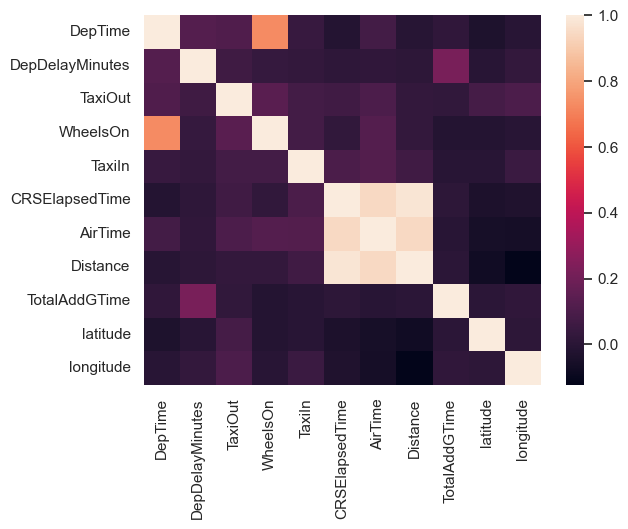

In [322]:
sns.heatmap(
    (df_flights_2
     .select_dtypes('float16')
     .corr()))
plt.show()


In [323]:
# Factors affecting delay
# Assumption: A flight is counted as "on time" if it operated less than 15 minutes later than the
def flight_status(df_flights):
        df_flights["FlightStatus"]="OnTime"

        df_flights.loc[df_flights["DepDel15"] == 0, "FlightStatus"]="OnTime"
        df_flights.loc[(df_flights["DepDelayMinutes"] >= 0) & (df_flights["DepDelayMinutes"] <= 15), "FlightStatus"]="OnTime"
        df_flights.loc[df_flights["WeatherDelay"] > 15, "FlightStatus"]="WeatherDelay"
        df_flights.loc[df_flights["NASDelay"] > 15, "FlightStatus"]="NASDelay"
        df_flights.loc[df_flights["SecurityDelay"] > 15, "FlightStatus"]="SecurityDelay"
        df_flights.loc[df_flights["LateAircraftDelay"] > 15, "FlightStatus"]="LateAircraftDelay"
        df_flights.loc[df_flights["CarrierDelay"] > 15, "FlightStatus"]="CarrierDelay"
        df_flights.loc[df_flights["Cancelled"], "FlightStatus"]="Cancelled"
    

flight_status(df_flights)

<AxesSubplot: xlabel='FlightDate'>

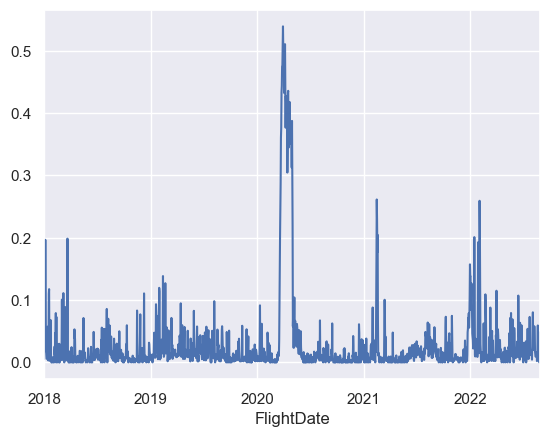

In [324]:
(df_flights.
 groupby("FlightDate")
 ["Cancelled"]
 .agg("mean")
 .plot()
 )


<AxesSubplot: xlabel='FlightDate'>

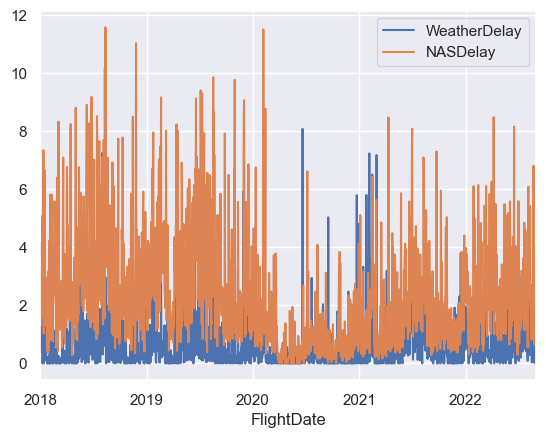

In [325]:
(df_flights.
 groupby("FlightDate")
 [["WeatherDelay", "NASDelay"]]
 .agg("mean")
 .plot())


<AxesSubplot: xlabel='FlightDate'>

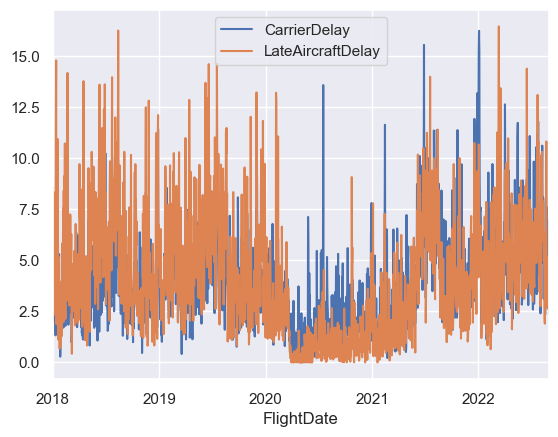

In [326]:
(df_flights.
 groupby("FlightDate")
 [["CarrierDelay", "LateAircraftDelay"]]
 .agg("mean")
 .plot())


##### Frequency Distribution Table

In [327]:
(df_flights
 [["Operating_Airline"]]
 .value_counts()
 .sort_values(ascending=False)
 .to_frame("Row Count")
 )


,Row Count
Operating_Airline,
Southwest Airlines Co.,140038
Delta Air Lines Inc.,84312
SkyWest Airlines Inc.,80966
American Airlines Inc.,80872
United Air Lines Inc.,59739
Republic Airlines,32624
JetBlue Airways,28167
Envoy Air,27331
Endeavor Air Inc.,25574


In [328]:
px.bar(
    df_flights["Operating_Airline"]
    .value_counts()
    .sort_values(ascending=True),
    orientation='h',
    template="plotly_dark",
    title="Flights per airline",
    height=700,
)


In [329]:
df_flights.head(3)

,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,Origin,OriginCityName,OriginState,OriginStateName,DestAirportID,Dest,DestCityName,DestState,DestStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,latitude,longitude,DepDelayClass,Year,Month,FlightStatus
0,2018-01-16,Endeavor Air Inc.,N8775A,3299,10397,ATL,"Atlanta, GA",GA,Georgia,11612,EVV,"Evansville, IN",IN,Indiana,939,932.0,-7.0,0.0,0.0,0900-0959,25.0,952.0,5.0,1008,957.0,0.0,0.0,1000-1059,0.0,none,False,89.0,55.0,350.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.6250,-84.4375,OnTime,2018,1,Cancelled
1,2018-01-22,Endeavor Air Inc.,N8946A,3299,10397,ATL,"Atlanta, GA",GA,Georgia,11612,EVV,"Evansville, IN",IN,Indiana,939,932.0,-7.0,0.0,0.0,0900-0959,17.0,951.0,4.0,1008,955.0,0.0,0.0,1000-1059,0.0,none,False,89.0,62.0,350.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.6250,-84.4375,OnTime,2018,1,Cancelled
2,2018-01-03,Endeavor Air Inc.,N8972E,3301,11617,EWN,"New Bern/Morehead/Beaufort, NC",NC,North Carolina,10397,ATL,"Atlanta, GA",GA,Georgia,1415,1420.0,5.0,0.0,5.0,1400-1459,12.0,1547.0,4.0,1605,1551.0,0.0,0.0,1600-1659,0.0,none,False,110.0,75.0,433.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0625,-77.0625,OnTime,2018,1,OnTime


In [330]:
(df_flights.
 groupby(["Flight_Number", "Tail_Number", "OriginCityName","DestCityName" ])
[["DepDelayMinutes"]]
#.agg(["mean", "sum"]).head(20)
)


In [331]:
cols = ["FlightDate","Tail_Number","Flight_Number","Operating_Airline", "OriginCityName","DestCityName", "CRSDepTime", "DepTime","DepDelayMinutes","AirTime", "FlightStatus"]
(df_flights
 .loc[df_flights["DepDelayMinutes"] >10, cols ]
 .sort_values(by=["Flight_Number", "FlightDate", "CRSDepTime"],ascending=[True, True, True]))

,FlightDate,Tail_Number,Flight_Number,Operating_Airline,OriginCityName,DestCityName,CRSDepTime,DepTime,DepDelayMinutes,AirTime,FlightStatus
14464,2018-02-22,N8696E,1,Southwest Airlines Co.,"Dallas, TX","Houston, TX",700,718.0,18.0,61.0,SecurityDelay
22380,2018-03-10,N965JB,1,JetBlue Airways,"New York, NY","Fort Lauderdale, FL",1011,1029.0,18.0,154.0,OnTime
26783,2018-03-28,N592AS,1,Alaska Airlines Inc.,"Washington, DC","Seattle, WA",800,817.0,17.0,336.0,OnTime
34124,2018-04-16,N903JB,1,JetBlue Airways,"New York, NY","Fort Lauderdale, FL",1011,1852.0,521.0,144.0,CarrierDelay
41657,2018-05-10,N957JB,1,JetBlue Airways,"New York, NY","Fort Lauderdale, FL",1025,1313.0,168.0,163.0,LateAircraftDelay
50803,2018-06-19,N474WN,1,Southwest Airlines Co.,"Houston, TX","Baltimore, MD",840,1026.0,106.0,167.0,CarrierDelay
60106,2018-07-04,N913JB,1,JetBlue Airways,"New York, NY","Fort Lauderdale, FL",1030,1132.0,62.0,137.0,LateAircraftDelay
59247,2018-07-18,N7874B,1,Southwest Airlines Co.,"Dallas, TX","Houston, TX",700,744.0,44.0,44.0,CarrierDelay
117469,2018-11-20,N8634A,1,Southwest Airlines Co.,"Houston, TX","Nashville, TN",855,906.0,11.0,83.0,OnTime
189372,2019-03-31,N382HA,1,Hawaiian Airlines Inc.,"Los Angeles, CA","Honolulu, HI",700,722.0,22.0,336.0,CarrierDelay


In [332]:
cols = ["FlightDate","Tail_Number","Flight_Number","Operating_Airline", "OriginCityName","DestCityName", "CRSDepTime", "DepTime","DepDelayMinutes","AirTime", "FlightStatus"]
(df_flights[cols]
 .groupby(["Flight_Number", "Operating_Airline"])
 [["DepDelayMinutes"]]
 .mean())

DepDelayMinutes
Flight_Number Operating_Airline                                         
1             Air Wisconsin Airlines Corp                            NaN
              Alaska Airlines Inc.                              3.487180
              Allegiant Air                                     0.000000
              American Airlines Inc.                            0.214286
              Cape Air                                               NaN
              Capital Cargo International                            NaN
              Comair Inc.                                            NaN
              Commutair Aka Champlain Enterprises, Inc.              NaN
              Compass Airlines                                       NaN
              Delta Air Lines Inc.                                   NaN
...                                                                  ...
9666          JetBlue Airways                                        NaN
              Mesa Airlines Inc.                                     NaN
              Peninsula Airways Inc.                                 NaN
              Republic Airlines                                      NaN
              SkyWest Airlines Inc.                            73.000000
              Southwest Airlines Co.                                 NaN
              Spirit Air Lines                                       NaN
              Trans States Airlines                                  NaN
              United Air Lines Inc.                                  NaN
              Virgin America                                         NaN

[198380 rows x 1 columns]

In [333]:
col2 = ["CarrierDelay","WeatherDelay",	"NASDelay",	"SecurityDelay","LateAircraftDelay", "FirstDepTime", "TotalAddGTime", "latitude", "longitude", "DepDelayClass"]
cols = ["FlightDate","CRSDepTime", "DepTime","DepDelayMinutes","AirTime", "FlightStatus"]	

Modelling

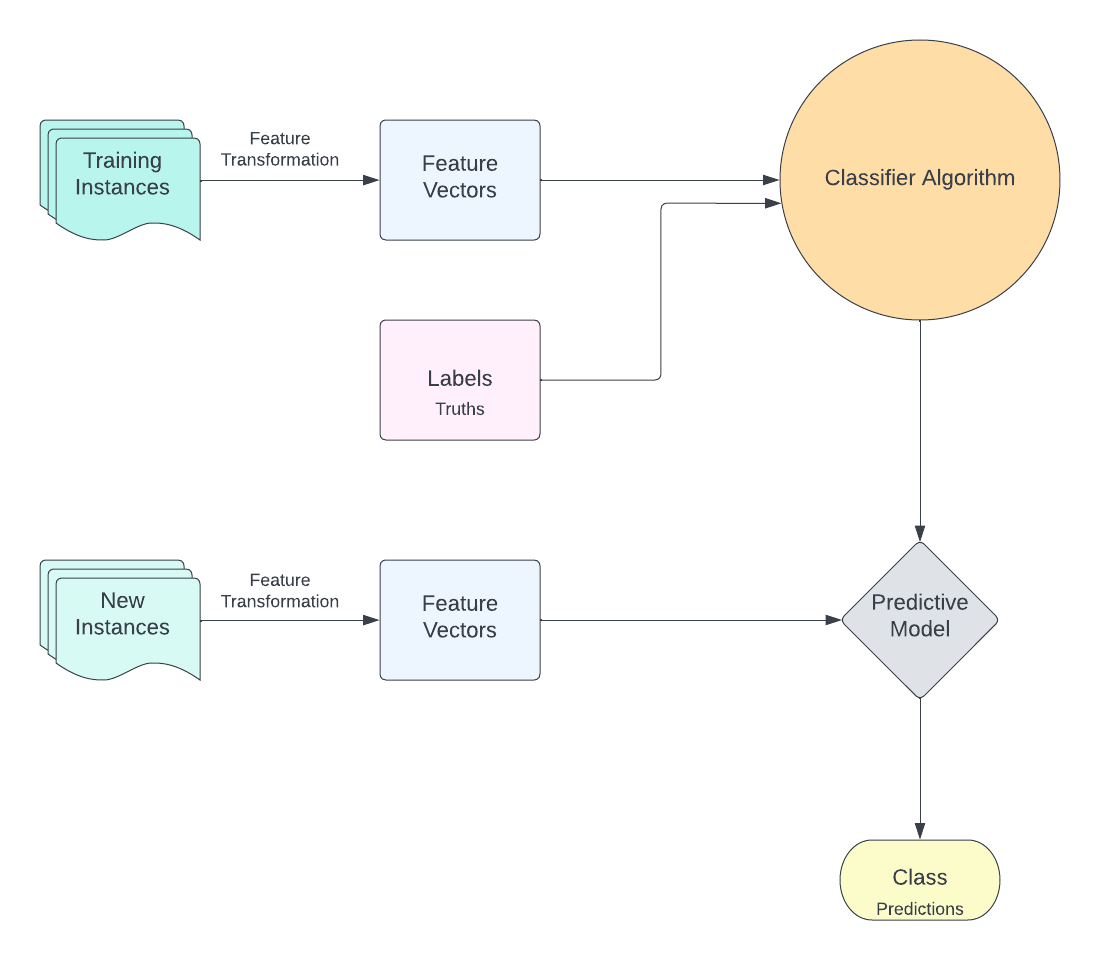

In [334]:
Image("../../data/images/ModellingWorkflow.png")

In [335]:
def fit_and_evaluate(X, y, model, label, **kwargs):
    """
    Because of the Scikit-Learn API, we can create a function to
    do all of the fit and evaluate work on our behalf!
    """
    start  = time.time() # Start the clock! 
    scores = {'precision':[], 'recall':[], 'accuracy':[], 'f1':[]}
    
    kf = KFold(n_splits = 12, shuffle=True)
    
    for train, test in kf.split(X, y):
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y[train], y[test]
        
        estimator = model(**kwargs) 
        estimator.fit(X_train, y_train)
        
        expected  = y_test
        predicted = estimator.predict(X_test)
        
        # Append our scores to the tracker
        scores['precision'].append(metrics.precision_score(expected, predicted, average="weighted"))
        scores['recall'].append(metrics.recall_score(expected, predicted, average="weighted"))
        scores['accuracy'].append(metrics.accuracy_score(expected, predicted))
        scores['f1'].append(metrics.f1_score(expected, predicted, average="weighted"))

    # Report
    print("Build and Validation of {} took {:0.3f} seconds".format(label, time.time()-start))
    print("Validation scores are as follows:\n")
    print(pd.DataFrame(scores).mean())
    
    # Write official estimator to disk
    estimator = model(**kwargs)
    estimator.fit(X, y)